## Basic text Classification
Training a binary classifier to perform sentiment analysis on an IMDB dataset.

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

print(tf. __version__)

2025-04-28 12:32:40.297945: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745843560.526073      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745843560.595614      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.18.0


## Sentiment Analysis

This notebook trains a sentiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review.

We will use the [Large Review Dataset](https://) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://). The are 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are *balanced*, meaning they contain an equal number of positive and negative reviews.



## Downloading and Exploring the IMDB dataset 

In [2]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = tf.keras.utils.get_file("aclImdb_v1", url, untar=True, cache_dir='.', cache_subdir="")
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84125825/84125825 ━━━━━━━━━━━━━━━━━━━━ 28s 0us/step


In [3]:
os.listdir(dataset_dir)

['imdb.vocab', 'imdbEr.txt', 'train', 'test', 'README']

In [4]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['neg',
 'pos',
 'unsup',
 'urls_pos.txt',
 'urls_unsup.txt',
 'unsupBow.feat',
 'urls_neg.txt',
 'labeledBow.feat']

The **aclImdb/train/pos** and **aclImdb/train/neg** directories contain many text files, each of which is a single movie review. Let's take a look at one of them.

In [5]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


## Loading the dataset

We will use the helpful [text_dataset_from_directory](http://) utility. Since we need two folders only, i.e. **class_a** and **class_b** which will be the positive and negative movie reviews, which can be found in **aclImdb/train/pos** and **aclImdb/train/neg**. Since the IMDB dataset contains other utilities we shall remove them before using this utility.

In [6]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

We will use the text_dataset_from_directory utility to create a labeled **[tf.data.Dataset](http://)**. [tf.data](http://) is a powerful collection of tools for working with data.

IMDB dataset has already been divided into train and test set but lacks validation test.

In [7]:
# Creating a validation set using an 80:20 split of the training data by using the validation_split argument
batch_size = 32
seed = 43

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


2025-04-28 12:33:52.648649: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Iterating over the dataset and printing out a few examples.

In [8]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

Review b"Difficult film to comment on, how do you say it's bad? Well it isn't, but then it's equally difficult to say it is good. What it is, is compelling viewing, it is as close as you will get to utter devastation without being there. It is the photographs of the tsunami approaching the coast of Thailand brought to life, you know you want to turn away but you have to watch.<br /><br />The Naudet brothers handle the commentary very well, even in the most tragic of circumstances, there view on something which is happening in another country neither panders nor insults. The facts are on the cellulose and little is needed for the viewer to understand or comprehend what is going on.<br /><br />You can't change history, and you should not want, this film stands as a testament to humanity in its darkest hour."
Label 1
Review b'I have seen over 1000 movies and this one stands out as one of the worst movies that I have ever seen. It is a shame that they had to associate this garbage to The A

Checking which of the above reviews are positive or negative movie reviews, we can check the **class_names** property of the dataset

In [9]:
print("label 0  corresponds to", raw_train_ds.class_names[0])
print("label 1 corresponds to", raw_train_ds.class_names[1])

label 0  corresponds to neg
label 1 corresponds to pos


In [10]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed
)

raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size
)


Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


## Preparing Dataset for Training



We use [tf.keras.layers.TextVectorization](http://) layer.

Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset. Tokenization refers to splitting strings into tokens(e.g. splitting a sentence into individual words).

Vectorization refers to converting tokens into numbers so they can be fed into a neural network

In [11]:
# custom standardization function to remove the HTML
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                   '[%s]' % re.escape(string.punctuation),
                                    '')

In [12]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

In [13]:
# Making a text_only dataset(without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y,: x)
vectorize_layer.adapt(train_text)

In [14]:
# Creating a function to see the result of using this layer to preprocess some data
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [15]:
# retrieving a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Melissa Sagemiller,Wes Bentley,Eliza Dushku and Casey Affleck play young students at Middleton College in the town of Middleton.The four teenagers form two love triangles.One night during an ominous full moon they drive and argue along a slippery and twisting mountain road.Not looking properly they careen into another car and one or more of them are killed.The ghostly nightmare begins...Pretty lousy and politically correct horror flick without gore and nudity.It\'s obviously influenced by "Carnival of Souls".The cinematography is decent,unfortunately there is zero suspense.4 out of 10-just another instantly forgettable teeny-bopper trash.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[5753,    1,    1,    1,    3,    1, 6918,  289,  180, 1436,   30,
           1, 1152,    8,    2,  499,    5,    1,  718, 2318,  809,  104,
         111,    1,  308,  306,   33, 5912,  378, 1782,   34, 1426,    3,
        3

# Each token has been replaced by an integer.
You can lookup the token(string) that each integer corresponds to by calling [.get_vocabulary()](http://) on the layer.

In [16]:
print("1287 ----> ", vectorize_layer.get_vocabulary()[1287])
print("217 ----> ", vectorize_layer.get_vocabulary()[217])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 ---->  twists
217 ---->  almost
Vocabulary size: 10000


In [17]:
# Applying the TextVectorization layer created earlier to the train, validation, and test dataset.
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_val_ds.map(vectorize_text)

# Configuring the dataset for performance

**.cache()** keeps data in memory after it's loaded off disk. This ensures the dataset does not become a bottleneck while training the model. if the dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

**.prefetch()** overlaps data preprocessing and model execution while training.

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Creating the Model

In [19]:
# Creating the model
embedding_dim = 16

model = tf.keras.Sequential([
    layers.Embedding(max_features, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

The layers are stacked sequentially to build the classifier:

1. The first layer is an **Embedding** layer. This layer takes the integer-encoded reviews and looks up an embedding vector for
   each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting
   dimensions are: **(batch, sequence, embedding)**. To learn more about embeddings, check out the [Word embeddings](http://) 
   tutorial.

2. Next, a **GlobalAveragePooling1D** layer returns a fixed-length output vector for each example by averaging over the sequence
   dimension. This allows the model to handle input of variable length, in the simplest way possible.

3. The last layer is densely connected with a single output node.


## Loss function and optimizer
A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), you'll use [losses.BinaryCrossentropy](http://) loss function.

In [20]:
# Configuring the model to use an optimizer and a loss function
model.compile(loss=losses.BinaryCrossentropy(),
             optimizer='adam',
             metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

## Training the model

In [21]:
# Passing the dataset object to the fit method
epochs = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.6126 - loss: 0.6792 - val_binary_accuracy: 0.7390 - val_loss: 0.6028
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - binary_accuracy: 0.7675 - loss: 0.5691 - val_binary_accuracy: 0.8140 - val_loss: 0.4880
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - binary_accuracy: 0.8300 - loss: 0.4572 - val_binary_accuracy: 0.8348 - val_loss: 0.4213
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - binary_accuracy: 0.8574 - loss: 0.3886 - val_binary_accuracy: 0.8430 - val_loss: 0.3830
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - binary_accuracy: 0.8690 - loss: 0.3444 - val_binary_accuracy: 0.8556 - val_loss: 0.3546
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - binary_accuracy: 0.8801 - loss: 0.3145 - val_binary_accuracy: 0.8606 - val_loss: 0.3369
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - binary_accuracy: 0.8896 - loss: 0.2900 - val_binary_accuracy: 0.8688 - val_loss: 0.3248
Epoch 

## Evaluating the model
Two values i.e. loss and accuracy, will be returned. A lower value for loss error is better.

In [22]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.8798 - loss: 0.3067
Loss:  0.30199959874153137
Accuracy:  0.8820000290870667


This approach achieves an accuracy of approximately 88%

## Creating a plot of accuracy and loss over time

**model.fit()** returns a **History** object that contains a dictionary with everything that happened during training.

In [23]:
history_dict =  history.history
history_dict.keys()

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])

These four entries: one for each monitored metric during training and validation. You can use these to plot the training and validation. These entries are used to plot the training and validation loss for comparison, as well as the training and validation accuracy:

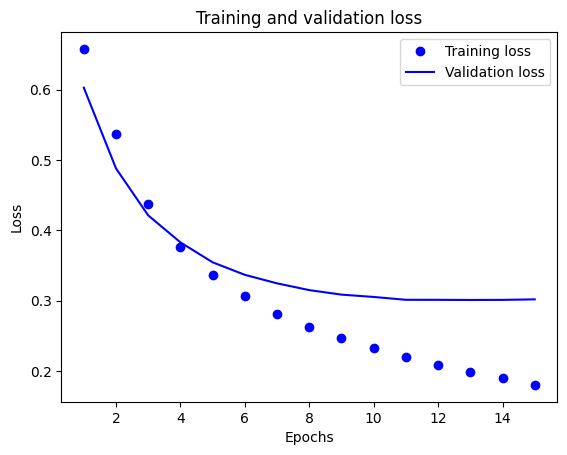

In [24]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')

# "b" for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

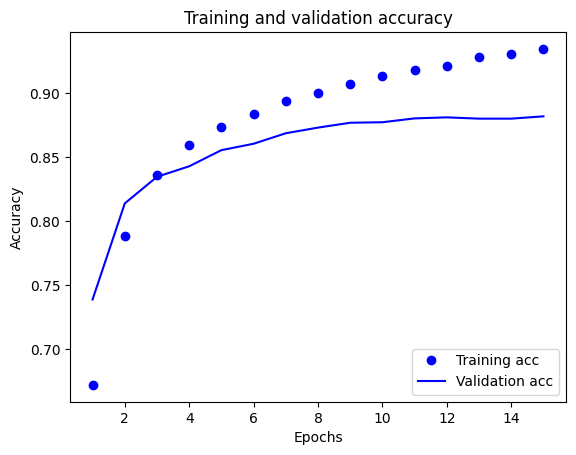

In [25]:
# "bo" is for "blue dot"
plt.plot(epochs, acc, 'bo', label='Training acc')
# "b" for "solid blue line"
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss decreases with each epoch and the training accuracy increases with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak before the training accuracy. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations specific to the training data that do not generalize to test data.

For this particular case, you could prevent overfitting by simply stopping the training when the validation accuracy is no longer increasing. One way to do so is to use the [tf.keras.callbacks.EarlyStopping callback](http://)

## Export the model
In the code above, we applied the **TextVectorization** layer to the dataset before feeding text to the model. If you want to make your model capable of processing raw strings (for example, to simplify deploying it), you can include the TextVectorization layer inside your model. To do so, you can create a new model using the weights you just trained.

In [26]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), 
    optimizer="adam", 
    metrics=['accuracy']
)

# Testing it with 'raw_test_ds', which yields raw strings
metrics = export_model.evaluate(raw_test_ds, return_dict=True)
print(metrics)


782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4977 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00
{'accuracy': 0.5003200173377991, 'binary_accuracy': 0.0, 'loss': 0.0}


## Inferencing on new data

To get new predictions for new examples, call **model.predict()**

In [27]:
examples = tf.constant([
    "The movie was amazing!",
    "I loved the movie, never gonna lie."
    "The movie was terrible..."
])

export_model.predict(examples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


array([[0.6335787],
       [0.5871764]], dtype=float32)

Including the text preprocessing logic inside your model enables you to export a model for production that simplifies deployment, and reduces the potential for [train/test skew](http://).

There is a performance difference to keep in mind when choosing where to apply your TextVectorization layer. Using it outside of your model enables you to do asynchronous CPU processing and buffering of your data when training on GPU. So, if you're training your model on the GPU, you probably want to go with this option to get the best performance while developing your model, then switch to including the TextVectorization layer inside your model when you're ready to prepare for deployment.